In [8]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator


In [26]:
backend = AerSimulator()


def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

Target state: |10000111101110101000⟩


C:\Users\k22ey1n\AppData\Local\Temp\ipykernel_21976\3185545062.py:14: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


Most probable outcome: 555944 with count: 1.0


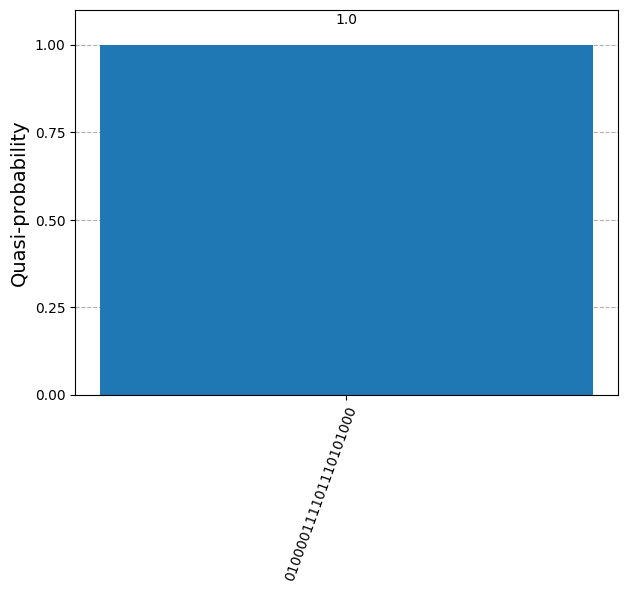

In [44]:
marked_number = int(input("Enter a number between 0 and 3: "))

def decimal_to_binary(n, bits=2):
    binary = []
    while n > 0:
        binary.append(str(n % 2))
        n //= 2
    while len(binary) < bits:
        binary.append('0')
    return ''.join(binary[::-1])

marked_state = decimal_to_binary(marked_number, bits=2)
print(f"Target state: |{marked_state}⟩")

marked_states = ["0" + marked_state]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)


qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")


shots = 10000
sampler = Sampler(mode=backend)
sampler.options.default_shots = shots
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

max_outcome = max(dist, key=dist.get)
max_count = dist[max_outcome]

def binary_to_decimal(binary_str):
    """Converts a binary string to its decimal equivalent."""
    decimal_value = 0
    power = 0
    for digit in reversed(binary_str):
        if digit == '1':
            decimal_value += 2 ** power
        elif digit != '0':
            raise ValueError("Invalid binary string: contains non-binary characters")
        power += 1
    return decimal_value

max_outcome = binary_to_decimal(max_outcome + "")
max_count = max_count / shots
print(f"Most probable outcome: {max_outcome} with count: {max_count}")

plot_distribution(dist)